In [ ]:
%load_ext autoreload
%autoreload 2

from rejax import PPO
import jax
from env import EnvParams, NavigationEnv
from rooms import RoomParams, generate_rooms

TRAIN_SEED = 11

# Initialize our environment
env = NavigationEnv()

# Generate rooms
room_params = RoomParams(
    size=4.0,
    grid_size=8,
    target_carved_percent=0.5,
    num_rooms=256,
)
room_key = jax.random.PRNGKey(TRAIN_SEED)
obstacles, free_positions = generate_rooms(room_key, room_params)

# Initialize environment parameters with generated rooms
env_params = EnvParams(
    lidar_max_distance=2.0,
    lidar_fov=120,
    lidar_num_beams=16,
    rooms=room_params,
    obstacles=obstacles,
    free_positions=free_positions,
)

# Initialize the training algorithm parameters
config = {
    # Pass our environment to the agent
    "env": env,
    "env_params": env_params,
    # Number of timesteps during which the agent will be trained
    "total_timesteps": 1_000_000,
}

# Create the training algorithm agent from `rejax` library
ppo = PPO.create(**config)

# Look at the whole configuration (we can experiment with all these parameters!)
ppo.config

{'env': <env.NavigationEnv at 0x12d49c2e0>,
 'env_params': {'max_steps_in_episode': 200,
  'wheel_base': 0.3,
  'max_wheel_speed': 1.0,
  'robot_radius': 0.15,
  'dt': 0.1,
  'rooms': {'size': 4.0,
   'grid_size': 8,
   'target_carved_percent': 0.5,
   'num_rooms': 256},
  'obstacles': Array([[[0. , 0. , 0.5, 0.5],
          [0.5, 0. , 0.5, 0.5],
          [1. , 0. , 0.5, 0.5],
          ...,
          [2.5, 3.5, 0.5, 0.5],
          [3. , 3.5, 0.5, 0.5],
          [3.5, 3.5, 0.5, 0.5]],
  
         [[0. , 0. , 0.5, 0.5],
          [0.5, 0. , 0.5, 0.5],
          [1. , 0. , 0.5, 0.5],
          ...,
          [2.5, 3.5, 0.5, 0.5],
          [3. , 3.5, 0.5, 0.5],
          [3.5, 3.5, 0.5, 0.5]],
  
         [[0. , 0. , 0.5, 0.5],
          [0.5, 0. , 0.5, 0.5],
          [1. , 0. , 0.5, 0.5],
          ...,
          [2.5, 3.5, 0.5, 0.5],
          [3. , 3.5, 0.5, 0.5],
          [3.5, 3.5, 0.5, 0.5]],
  
         ...,
  
         [[0. , 0. , 0.5, 0.5],
          [0.5, 0. , 0.5, 0.5],
 

## Training

In [2]:
import jax
import time

# Set the seed for reproducibility
TRAIN_SEED = 13

# Set training seed and jit train function
rng = jax.random.PRNGKey(TRAIN_SEED)
train_fn = jax.jit(ppo.train)

print("Starting to train")

# Train!
start = time.time()
train_state, evaluation = train_fn(rng)
time_elapsed = time.time() - start

sps = ppo.total_timesteps / time_elapsed
print(f"Finished training in {time_elapsed:g} seconds ({sps:g} steps/second).")

Starting to train
Finished training in 4.43512 seconds (225473 steps/second).


## Evaluation

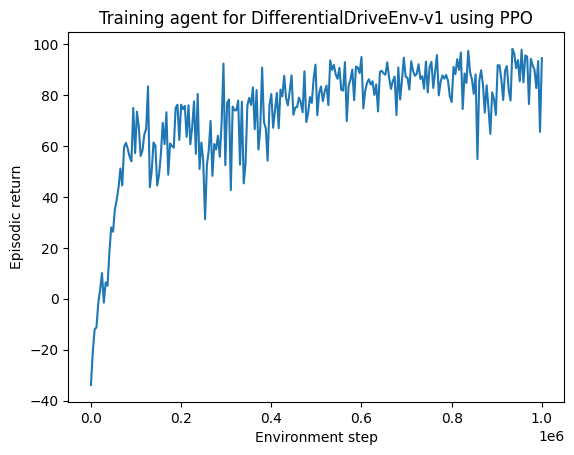

In [3]:
from matplotlib import pyplot as plt

episode_lengths, episode_returns = evaluation
mean_return = episode_returns.mean(axis=1)

plt.plot(jax.numpy.linspace(0, ppo.total_timesteps, len(mean_return)), mean_return)
plt.xlabel("Environment step")
plt.ylabel("Episodic return")
plt.title(f"Training agent for {env.name} using {ppo.__class__.__name__}")
plt.show()

Running 10 episodes and collecting frames...
  Episode 1 finished after 23 steps.
  Episode 2 finished after 19 steps.
  Episode 3 finished after 8 steps.
  Episode 4 finished after 18 steps.
  Episode 5 finished after 16 steps.
  Episode 6 finished after 28 steps.
  Episode 7 finished after 20 steps.
  Episode 8 finished after 1 steps.
  Episode 9 finished after 21 steps.
  Episode 10 finished after 46 steps.
Finished 10 episodes. Total steps: 200. Total frames: 200.
Saving GIF...
GIF saved to temp/navigation_policy.gif


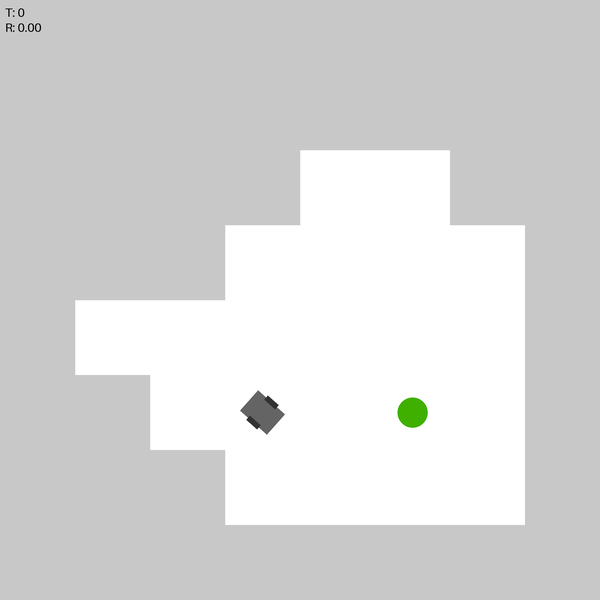

GIF saved as temp/navigation_policy.gif


In [ ]:
from IPython.display import Image as IPImage, display
import env_vis
import os

# --- Configuration ---
N_EPISODES = 10  # Number of episodes to run
TEST_SEED = 43


# --- 1. Get Agent ---
t0 = time.time()
act = jax.jit(ppo.make_act(train_state))
key = jax.random.PRNGKey(TEST_SEED)

# List to store frames for GIF
frames = []
total_steps = 0  # Keep track of total steps across episodes

print(f"Running {N_EPISODES} episodes and collecting frames...")

# --- 3. Run Episodes & Collect Frames ---
for i_episode in range(N_EPISODES):
    key, reset_key = jax.random.split(key)
    obs, state = env.reset(reset_key, env_params)
    done = False
    episode_steps = 0

    while not done:
        # Render current state to frame
        frame = env_vis.render_frame(state, env_params)
        frames.append(frame)

        # Choose action and step environment
        key, act_key, step_key = jax.random.split(key, 3)
        action = act(obs, act_key)
        obs, state, _, done, _ = env.step(step_key, state, action, env_params)
        episode_steps += 1

    print(f"  Episode {i_episode + 1} finished after {episode_steps} steps.")
    total_steps += episode_steps

print(f"Finished {N_EPISODES} episodes. Total steps: {total_steps}. Total frames: {len(frames)}.")

# --- 4. Save and Display GIF ---
print("Saving GIF...")
os.makedirs("temp", exist_ok=True)
gif_filename = "temp/navigation_policy.gif"
env_vis.save_gif(frames, gif_filename, duration_per_frame=env_params.dt)

# Display the GIF in the notebook
display(IPImage(filename=gif_filename))
print(f"GIF saved as {gif_filename}")